# Figure 02. Correlations between differences in susceptibility to

toxicant conditions

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'cowplot'

The following object is masked from 'package:lubridate':

    stamp

here() starts at /Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript

In [ ]:
source("bin/outs.R")



Attaching package: 'data.table'

The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows


Attaching package: 'flextable'

The following objects are masked from 'package:kableExtra':

    as_image, footnote

The following object is masked from 'package:purrr':

    compose

$strain_table
$strain_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.html"

$strain_table$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.tsv.zip"

$strain_table$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.docx"

$strain_table$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.csv"


$tox_table_ft
$tox_table_ft$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.html"

$tox_table_ft$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.tsv.zip"

$tox_table_ft$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.docx"

$tox_table_ft$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.csv"


$trait_table
$trait_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S3/table_S3.html"

$trait_table$tsv
[1] "

In [ ]:
# Load correlation data
pheno_corr_all <- readRDS(file.path("data/processed/phenotypes/pheno_corr_all.Rds"))
tox_data <- data.table::fread(file.path("data/processed/tox_data/con_metadata.csv"))
strain_means_pivot_matrix <- readRDS(file.path("data/processed/phenotypes/strain_means_matrix.rds"))


Report out the average correlation across all toxicant conditions

In [ ]:
init_corr_coef <- pheno_corr_all$r

corr_coef_df <- as_tibble(init_corr_coef, rownames = "trait1") %>%
  pivot_longer(-trait1, names_to = "trait2", values_to = "r_value")

# calculate the average correlation
pheno_corr_all_avg <- corr_coef_df %>%
  dplyr::filter(trait1 != trait2) %>%
  dplyr::summarise(
    mean_r = mean(r_value, na.rm = TRUE),
    sd_r = sd(r_value, na.rm = TRUE),
    q1_r = quantile(r_value, probs = 0.25, na.rm = TRUE),
    q3_r = quantile(r_value, probs = 0.75, na.rm = TRUE),
    upper_threshold_r = q3_r + 1.5 * (q3_r - q1_r),
    lower_threshold_r = q1_r - 1.5 * (q3_r - q1_r)
  )
pheno_corr_all_avg


# A tibble: 1 × 6
  mean_r  sd_r   q1_r  q3_r upper_threshold_r lower_threshold_r
   <dbl> <dbl>  <dbl> <dbl>             <dbl>             <dbl>
1  0.189 0.152 0.0801 0.296             0.621            -0.244

To annotate the cells of the clustered heatmap reprocess the correlation data after performing the clustering so that the annotation matricies align with the clusterd conditions

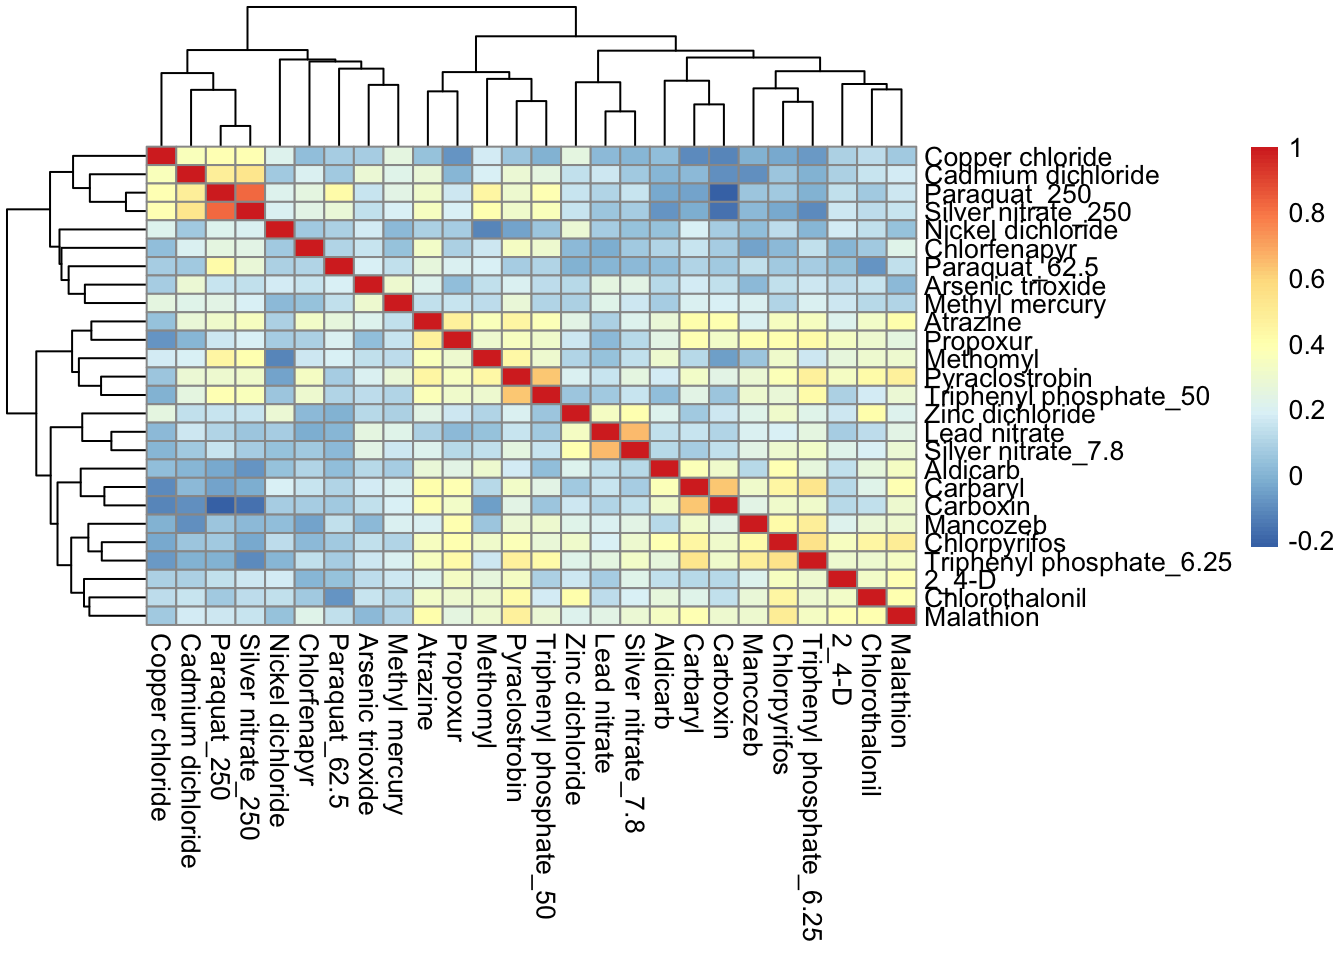

In [ ]:
# perform clustering on pairwise Spearman correlation coefficients
clust <- pheatmap::pheatmap(init_corr_coef)


Check to identify significant correlations:

Lower triangle with un-corrected p-valyes

In [ ]:
# pull the lower and top diagonals for detailed analysis
# 299 pos, 26 neg
# lower raw
# 185 pos, 2 neg sig raw
lower_r_raw <- pheno_corr_all2$r
lower_r_raw[upper.tri(lower_r_raw, diag = T)] <- NA_real_
lower_r_proc <- as_tibble(lower_r_raw) %>%
  dplyr::mutate(y_trait = row.names(lower_r_raw)) %>%
  tidyr::pivot_longer(cols = -y_trait, names_to = "x_trait", values_to = "r") %>%
  dplyr::filter(!is.na(r)) %>%
  dplyr::mutate(
    neg_n = sum(r < 0),
    pos_n = sum(r > 0)
  )

lower_p_raw <- pheno_corr_all2$p
lower_p_raw[upper.tri(lower_p_raw, diag = T)] <- NA_real_
lower_p_proc <- as_tibble(lower_p_raw) %>%
  dplyr::mutate(y_trait = row.names(lower_p_raw)) %>%
  tidyr::pivot_longer(cols = -y_trait, names_to = "x_trait", values_to = "raw_p") %>%
  dplyr::filter(!is.na(raw_p)) %>%
  dplyr::mutate(`raw_p<0.05` = ifelse(raw_p < 0.05, T, F))

lower_proc <- dplyr::left_join(lower_r_proc, lower_p_proc) %>%
  dplyr::mutate(
    pos_sig_n = sum(r > 0 & `raw_p<0.05` == T),
    neg_sig_n = sum(r < 0 & `raw_p<0.05` == T)
  )


Joining with `by = join_by(y_trait, x_trait)`

Upper triangle with Bonferroni corrected p-values

In [ ]:
# top or bonferroni corrected
# 88 pos, 0 neg sig
top_r_raw <- pheno_corr_all2$r
top_r_raw[lower.tri(top_r_raw, diag = T)] <- NA_real_
top_r_proc <- as_tibble(top_r_raw) %>%
  dplyr::mutate(y_trait = row.names(top_r_raw)) %>%
  tidyr::pivot_longer(cols = -y_trait, names_to = "x_trait", values_to = "r") %>%
  dplyr::filter(!is.na(r)) %>%
  dplyr::mutate(
    neg_n = sum(r < 0),
    pos_n = sum(r > 0)
  )

top_p_raw <- pheno_corr_all2$p
top_p_raw[lower.tri(top_p_raw, diag = T)] <- NA_real_
top_p_proc <- as_tibble(top_p_raw) %>%
  dplyr::mutate(y_trait = row.names(top_p_raw)) %>%
  tidyr::pivot_longer(cols = -y_trait, names_to = "x_trait", values_to = "BF_p") %>%
  dplyr::filter(!is.na(BF_p)) %>%
  dplyr::mutate(`BF_p<0.05` = ifelse(BF_p < 0.05, T, F))

top_proc <- dplyr::left_join(top_r_proc, top_p_proc) %>%
  dplyr::mutate(
    pos_sig_n = sum(r > 0 & `BF_p<0.05` == T),
    neg_sig_n = sum(r < 0 & `BF_p<0.05` == T)
  )


Joining with `by = join_by(y_trait, x_trait)`

# A tibble: 325 × 9
   y_trait   x_trait       r neg_n pos_n    BF_p `BF_p<0.05` pos_sig_n neg_sig_n
   <chr>     <chr>     <dbl> <int> <int>   <dbl> <lgl>           <int>     <int>
 1 Copper c… Cadmiu…  0.363     26   299 8.47e-5 TRUE               88         0
 2 Copper c… Paraqu…  0.387     26   299 9.37e-6 TRUE               88         0
 3 Copper c… Silver…  0.383     26   299 2.19e-5 TRUE               88         0
 4 Copper c… Nickel…  0.213     26   299 9.52e-1 FALSE              88         0
 5 Copper c… Chlorf…  0.0319    26   299 1   e+0 FALSE              88         0
 6 Copper c… Paraqu…  0.0801    26   299 1   e+0 FALSE              88         0
 7 Copper c… Arseni…  0.0765    26   299 1   e+0 FALSE              88         0
 8 Copper c… Methyl…  0.252     26   299 1.38e-1 FALSE              88         0
 9 Copper c… Atrazi…  0.0426    26   299 1   e+0 FALSE              88         0
10 Copper c… Propox… -0.0794    26   299 1   e+0 FALSE              88         0
# ℹ 315 

In [ ]:
# Create the color palette and annotation data


# Set color palette for annotations
class.pal.df <- tibble::tibble(
  col = c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00"),
  big_class = c("Flame Retardant", "Fungicide", "Herbicide", "Insecticide", "Metal")
)

# filter the meta data to include only toxicant and join to the class palette
tox_cols <- tox_data %>%
  # remove the controls
  dplyr::filter(big_class != "Control") %>%
  dplyr::select(drug, nice_drug_label2, big_class, moa_class) %>%
  # Clean up to have special character for plotting
  dplyr::mutate(nice_drug_label2 = stringr::str_replace(nice_drug_label2, pattern = "uM", replacement = "µM")) %>%
  # join to the class palette
  dplyr::left_join(., class.pal.df, by = c("big_class" = "big_class")) %>%
  dplyr::select(drug, nice_drug_label2, big_class, moa_class, col) %>%
  dplyr::rename(MoA = moa_class, Use = big_class) %>%
  # In moa_class column replace Other|unknown with "Other / unknown"
  dplyr::mutate(MoA = stringr::str_replace(MoA, pattern = "Other\\|unknown", replacement = "Other / unknown"))

# Create a mapping from drug to nice_drug_label2
drug_to_label <- setNames(tox_cols$nice_drug_label2, tox_cols$drug)


# Update row and column names of correlation matrices
rownames(pheno_corr_all_r) <- drug_to_label[rownames(pheno_corr_all_r)]
colnames(pheno_corr_all_r) <- drug_to_label[colnames(pheno_corr_all_r)]
rownames(pheno_corr_all_p_symbol) <- drug_to_label[rownames(pheno_corr_all_p_symbol)]
colnames(pheno_corr_all_p_symbol) <- drug_to_label[colnames(pheno_corr_all_p_symbol)]

moa_anno_df <- tox_cols %>%
  # set the row names to the nice drug label
  tibble::column_to_rownames(var = "nice_drug_label2") %>%
  # rename the big class column to Class
  # dplyr::rename(Class = Use) %>%
  # remove the drug and color columns
  dplyr::select(-drug, -col)
# In moa_class column replace Other|unknown with "Other / unknown"
# dplyr::mutate(moa_class = stringr::str_replace(moa_class, pattern = "Other|unknown", replacement = "Other / unknown")) %>%
# dplyr::rename(MoA = moa_class, Use = Class)


# Create annotation colors
cols <- unique(class.pal.df$col)
names(cols) <- unique(class.pal.df$big_class)
anno_cols <- list(Use = cols)


In [ ]:
create_phenotype_heatmap <- function(similarity_matrix, con_metadata_df, anno_cols, significance_matrix) {
  # Perform hierarchical clustering on rows to get the dendrogram
  row_dist <- dist(similarity_matrix)
  row_hclust <- hclust(row_dist)

  # Use the same clustering order for both rows and columns
  # (since it's a symmetric similarity matrix)
  p <- pheatmap::pheatmap(
    similarity_matrix,
    annotation_row = con_metadata_df,
    annotation_colors = anno_cols,
    width = 7.5,
    height = 6,
    color = colorRampPalette(c("navy", "white", "darkred"))(1000),
    breaks = seq(-1, 1, length.out = (1000 + 1)),
    show_colnames = TRUE,
    fontsize_number = 12,
    display_numbers = significance_matrix,
    cluster_rows = row_hclust,
    cluster_cols = FALSE,
    cutree_rows = 2,
    silent = TRUE
  )
  return(p)
}


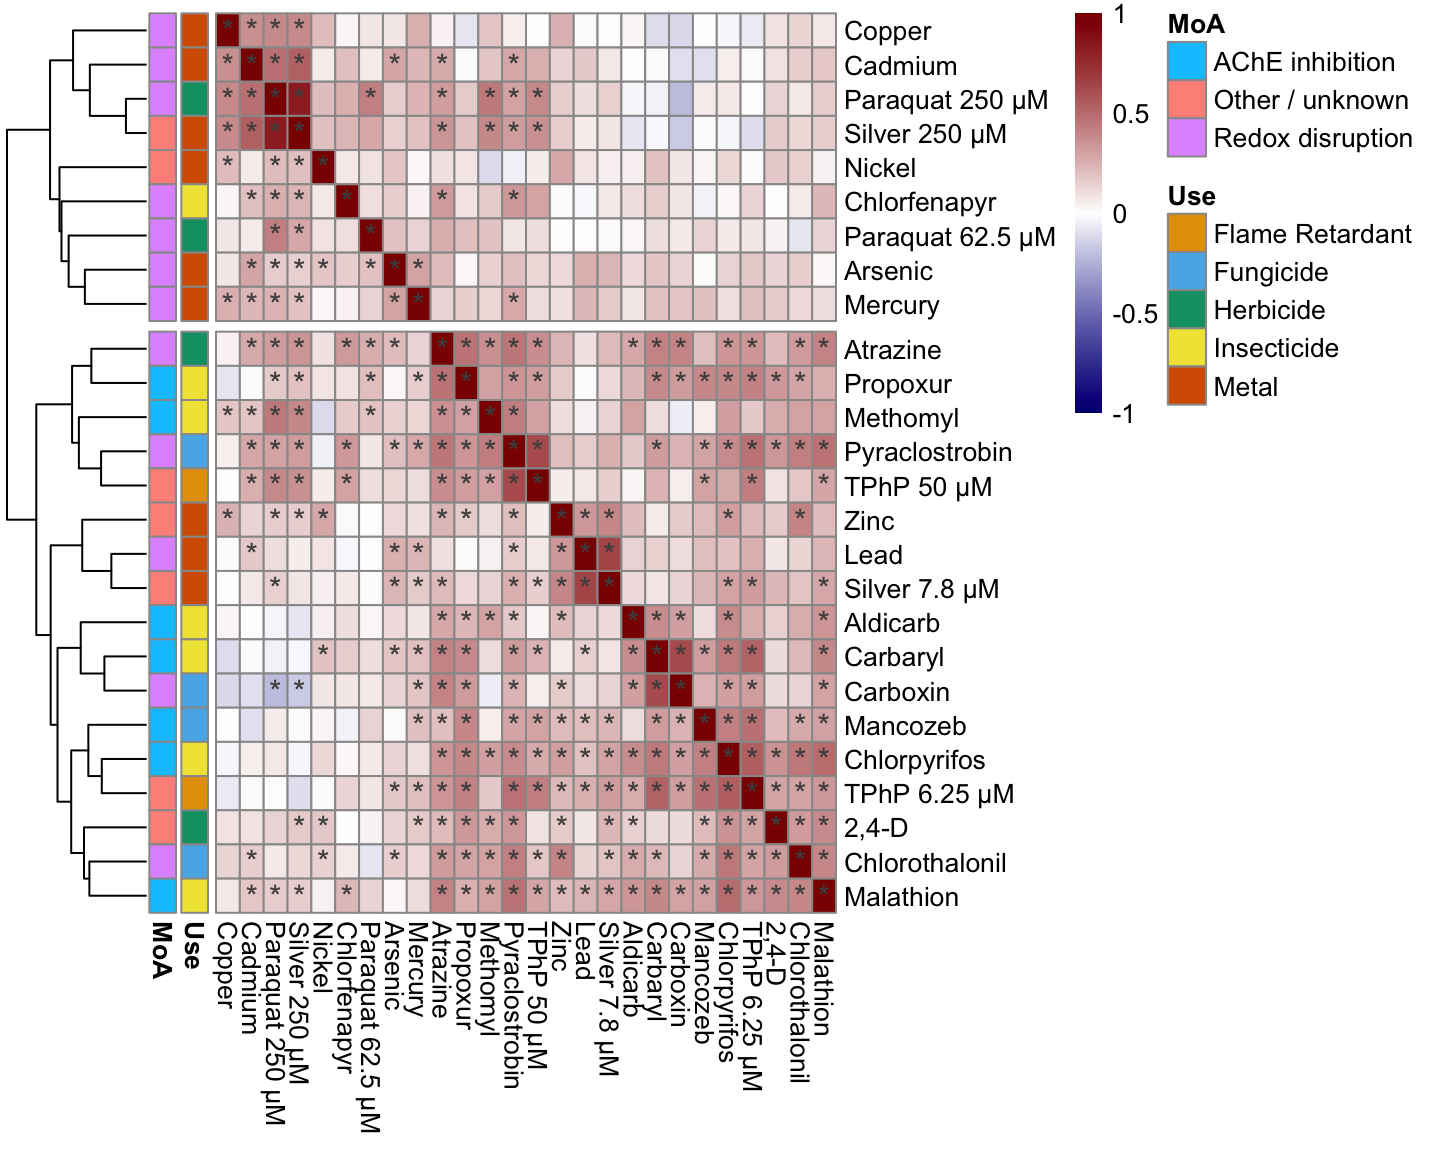

In [ ]:
phenotype_correlations <- create_phenotype_heatmap(
  similarity_matrix = pheno_corr_all_r,
  con_metadata_df = moa_anno_df,
  significance_matrix = pheno_corr_all_p_symbol,
  anno_cols = anno_cols
)
phenotype_correlations


Save publication figure

In [ ]:
save_plot(
  tplot = phenotype_correlations,
  fn_list = figure_fns$phenotype_correlations,
  w_in = 7.5,
  h_in = 5
)
